# Imports

In [75]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import os
import librosa.display


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torchsummary import summary
from tqdm import tqdm

# Hyperparameters / Settings

In [58]:
sf = 8000
batch_size = 4

# Dataset Prep

## One data load

In [10]:
one_data = '/mnt/c/Users/user/Desktop/Roshidat/Workspace/PD_prediction/data/1_data/HC_AH/AH_064F_7AB034C9-72E4-438B-A9B3-AD7FDA1596C5.wav'
data_one, _ = librosa.load(one_data, sr=sf)

In [8]:
data_one.shape

(29911,)

## Load all HC data

In [16]:
path = '/mnt/c/Users/user/Desktop/Roshidat/Workspace/PD_prediction/data/1_data/HC_AH'
dirc = os.listdir(path)

In [17]:
file_path = os.path.join(path, dirc[0])
loaded_file, _= librosa.load(file_path, sr=sf)
loaded_file.shape

(29911,)

In [18]:
hc_data = []
for file in dirc:
    file_path = os.path.join(path, file)
    loaded_file, _ = librosa.load(file_path, sr=sf)
    hc_data.append(loaded_file)

In [19]:
len(hc_data)

41

In [26]:


# Find the maximum length among all arrays in hc_data
max_len = max([arr.shape[0] for arr in hc_data])

# Pad each array with zeros at the end to match max_len
hc_data_padded = [np.pad(arr, (0, max_len - arr.shape[0]), mode='constant') for arr in hc_data]

# Optionally, convert to a numpy array
hc_data_padded = np.stack(hc_data_padded)

In [28]:
max_len

46109

In [31]:
hc_data_padded.shape

(41, 46109)

In [36]:
hc_data_padded = hc_data_padded[:,:40000]
hc_data_padded.shape

(41, 40000)

In [37]:
y_hc = np.zeros(hc_data_padded.shape[0])  # Create an array of zeros with the same length as hc_data_padded
y_hc

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

## Load all PD data

In [20]:
pd_path = '/mnt/c/Users/user/Desktop/Roshidat/Workspace/PD_prediction/data/1_data/PD_AH'
pd_dirc = os.listdir(pd_path)

pd_data = []
for file in pd_dirc:
    file_path = os.path.join(pd_path, file)
    loaded_file, _ = librosa.load(file_path, sr=sf)
    pd_data.append(loaded_file)

In [22]:
len(pd_data)

40

In [33]:


# Find the maximum length among all arrays in pd_data
max_len = max([arr.shape[0] for arr in pd_data])

# Pad each array with zeros at the end to match max_len
pd_data_padded = [np.pad(arr, (0, max_len - arr.shape[0]), mode='constant') for arr in pd_data]

# Optionally, convert to a numpy array
pd_data_padded = np.stack(pd_data_padded)

In [34]:
pd_data_padded.shape

(40, 57664)

In [38]:
pd_data_padded = pd_data_padded[:,:40000]
pd_data_padded.shape

(40, 40000)

In [35]:
y_pd = np.zeros(pd_data_padded.shape[0])+1  # Create an array of zeros with the same length as hc_data_padded
y_pd

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1.])

## Concatenate

In [40]:
X  =  np.concatenate((hc_data_padded, pd_data_padded), axis=0)
y = np.concatenate((y_hc, y_pd), axis=0)

In [41]:
X.shape

(81, 40000)

In [45]:
y[0:42]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1.])

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [48]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((64, 40000), (17, 40000), (64,), (17,))

Text(0.5, 1.0, 'Count per Label in y_train')

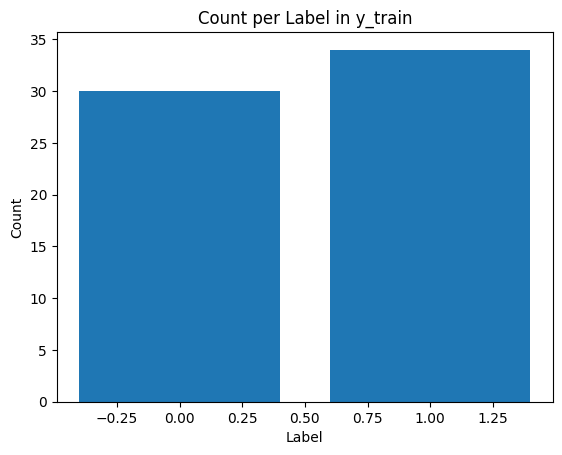

In [50]:


# Plot the count per label in y_train
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count per Label in y_train')

# Feature Extraction

## MFCC from single file

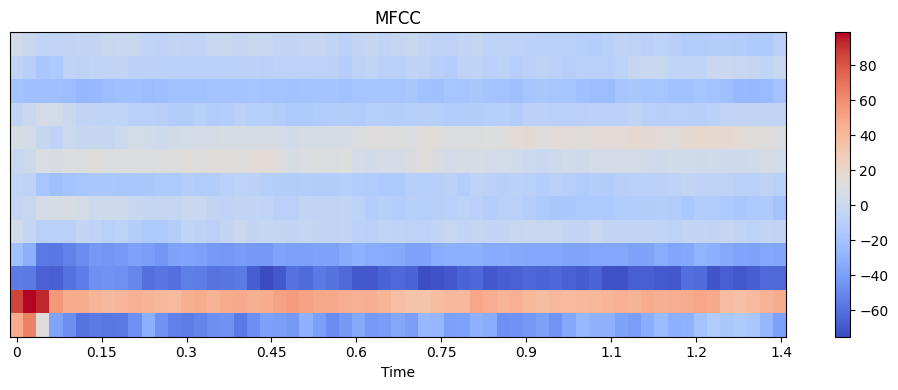

In [24]:
mfccs = librosa.feature.mfcc(y=data_one, sr=sf, n_mfcc=13)

# Display the MFCCs as an image
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()
# ...existing code...

In [25]:
mfccs.shape

(13, 59)

## Data Extraction from Multiple data

In [53]:
def get_mfcc(data, sample_rate, window):
    mfccs_list = []
    for dat in data:
        mfccs = librosa.feature.mfcc(y=dat, sr=sample_rate, n_mfcc=window)
        mfccs_list.append(mfccs)
    return np.array(mfccs_list)

In [54]:
X_train_mfcc = get_mfcc(X_train, sample_rate=sf, window=13)
X_test_mfcc = get_mfcc(X_test, sample_rate=sf, window=13)

In [96]:
X_train_mfcc.shape, X_test_mfcc.shape

((64, 13, 79), (17, 13, 79))

In [98]:
X_train_mfcc.reshape(64,-1).shape

(64, 1027)

In [99]:
13*79

1027

In [56]:
X_train_mfcc_exp = np.expand_dims(X_train_mfcc, axis=1)
X_test_mfcc_exp = np.expand_dims(X_test_mfcc, axis=1)

X_train_mfcc_exp.shape, X_test_mfcc_exp.shape

((64, 1, 13, 79), (17, 1, 13, 79))

In [60]:
X_test_mfcc_exp = torch.tensor(X_test_mfcc_exp, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

X_train_mfcc_exp = torch.tensor(X_train_mfcc_exp, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

In [61]:
train_data = TensorDataset(X_train_mfcc_exp, y_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

test_data = TensorDataset(X_test_mfcc_exp, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


In [62]:
check = next(iter(train_loader))
check[0].shape, check[1].shape

(torch.Size([4, 1, 13, 79]), torch.Size([4]))

# Model Architecture

In [77]:
32 * 7 * 31

6944

In [91]:
class PD_Classifier(nn.Module):
    def __init__(self, num_classes=2):
        super(PD_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(0.5)  # Add dropout layer to prevent overfitting
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(7488, 64)  # Adjust input size based on your MFCC shape
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = self.fc2(x)
        x = self.sigmoid(x)  # Use sigmoid for binary classification
        return x

# Example usage:
# model = PD_Classifier(num_classes=2)
# print(model)

In [92]:
model = PD_Classifier(num_classes=2)
model

PD_Classifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=7488, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [69]:
# summary(model, (1, 13, 79))

# Training

In [93]:
# Training loop for PD_Classifier (single output neuron, sigmoid activation)
num_epochs = 10
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [94]:
for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)  # Ensure shape (batch, 1) and float type
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

 20%|██        | 2/10 [00:00<00:01,  7.45it/s]

Epoch 1/10, Loss: 17.6561, Accuracy: 0.5625
Epoch 2/10, Loss: 1.6630, Accuracy: 0.6094
Epoch 3/10, Loss: 0.6415, Accuracy: 0.6094


 60%|██████    | 6/10 [00:00<00:00, 10.65it/s]

Epoch 4/10, Loss: 0.5689, Accuracy: 0.7188
Epoch 5/10, Loss: 0.4395, Accuracy: 0.8281
Epoch 6/10, Loss: 0.4717, Accuracy: 0.8438


 80%|████████  | 8/10 [00:00<00:00, 11.44it/s]

Epoch 7/10, Loss: 0.2760, Accuracy: 0.9062
Epoch 8/10, Loss: 0.2108, Accuracy: 0.9062
Epoch 9/10, Loss: 0.2613, Accuracy: 0.8906


100%|██████████| 10/10 [00:00<00:00, 10.61it/s]

Epoch 10/10, Loss: 0.1954, Accuracy: 0.9375


# Evaluation

In [95]:
# Evaluation on test set
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float()
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)
test_loss = test_loss / test_total
test_acc = test_correct / test_total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 0.7573, Test Accuracy: 0.5882


In [ ]:
# # Training loop for PD_Classifier
# num_epochs = 10
# learning_rate = 0.001

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     correct = 0
#     total = 0
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item() * inputs.size(0)
#         _, predicted = torch.max(outputs, 1)
#         correct += (predicted == labels).sum().item()
#         total += labels.size(0)
#     epoch_loss = running_loss / total
#     epoch_acc = correct / total
#     print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

loss = nn.